# 0. Imports and functions definitions

In [1]:
import uproot, os
import numpy             as np
import matplotlib.pyplot as plt

In [2]:
def extract_branches(folder,root_file,sensors,branches={"Photons":["X","Y","Z","Phi","Theta","Sensor"],"Hits":["Sensor","AccumHits"]},debug=False):
    opened_file = uproot.open(folder+root_file)
    branch_dict = dict.fromkeys(branches.keys())
    my_data = dict.fromkeys([root_file]); my_data[root_file] = dict.fromkeys(sensors)
    for k,key in enumerate(branch_dict):
        branch_dict[key] = {}
        for branch in branches[key]: 
            branch_dict[key][branch] = opened_file[key][branch].array().to_numpy();
    for s,sensor in enumerate(sensors):
        my_data[root_file][sensor] = {}
        for k,key in enumerate(branch_dict):
            for branch in branches[key]: 
                my_data[root_file][sensor][branch] = branch_dict[key][branch][branch_dict[key]["Sensor"]==s]
    if debug: print(my_data)
    return my_data

def compute_real_angles(my_data,sensors_info,debug=False):
    for geo_file in my_data.keys():
        for sensor in my_data[geo_file].keys():
            phi   = my_data[geo_file][sensor]["Phi"]
            theta = my_data[geo_file][sensor]["Theta"]
            
            abs_vec = np.array([ np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
            norm    = np.sum(  (abs_vec.T*sensors_info[sensor][geo_file]),axis=1 )
            inc_ang = np.arccos(norm)
            
            my_data[geo_file][sensor]["vector"]        = abs_vec
            my_data[geo_file][sensor]["norm"]          = norm
            my_data[geo_file][sensor]["inc_ang"]       = inc_ang
            if   ((np.mean(inc_ang)>np.pi/2)): my_data[geo_file][sensor]["inc_ang_fixed"] = np.pi - inc_ang
            else                             : my_data[geo_file][sensor]["inc_ang_fixed"] = inc_ang
    if debug: print(sensors_info)

def plot_angular_distributions(my_data,dpi=50):
    fig = plt.figure(dpi=dpi)
    for my_file in my_data.keys():
        plt.title(my_file.replace(".root",""))
        for sensor in my_data[my_file]:
            plt.hist (my_data[my_file][sensor]["inc_ang_fixed"]*180/np.pi,45,[0,90],alpha=.5,density=True,label=sensor)
        plt.xlabel("Incident angle (°)")
        plt.legend()
        plt.show()
    return fig
    

def plot_photon_density(my_data,sensors_info,dpi=50):
    axes   = ["X","Y","Z"]
    labels = ["X axis", "Y axis", "Z axis"]
    fig = plt.figure(dpi=dpi)
    for my_file in my_data:
        for sensor in my_data[my_file]: 
            plt.figure()
            plt.title(my_file.replace(".root","_")+sensor)
            axes2plot = list((np.abs(sensors_info[sensor][my_file])-1)*(-1))
            axes2plot = np.where(np.array(axes2plot)==1)[0]
            plt.hist2d(my_data[my_file][sensor][axes[axes2plot[0]]],my_data[my_file][sensor][axes[axes2plot[1]]])
            plt.xlabel(labels[axes2plot[0]])
            plt.ylabel(labels[axes2plot[1]])
            plt.colorbar()
            plt.show()
    return fig

def plot_acumhits(my_data,dpi=50,bins=[100,35,35],semilogy=False):
    for my_file in my_data:
        fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,dpi=dpi)
        fig.suptitle(my_file.replace(".root",""))
        means = []
        for s,sensor in enumerate(my_data[my_file]): 
            mean = np.mean(my_data[my_file][sensor]["AccumHits"]); means.append(mean)
            if len(means) == 1: 
                ax2.hist (my_data[my_file][sensor]["AccumHits"], bins[s], alpha=0.5, histtype="step", color="C"+str(s),label=sensor+" (Mean %0.2f)"%mean)
                ax2.set_xlim(mean-mean*0.2,mean+mean*0.2)
            else: 
                if np.any(np.array(means/mean) < 0.1) or np.any(np.array(means/mean) > 30): 
                    ax1.hist(my_data[my_file][sensor]["AccumHits"], bins[s], alpha=0.5, histtype="step", color="C"+str(s), label=sensor+" (Mean %0.2f)"%mean)
                    ax1.set_xlim(mean-mean*0.8,mean+mean*1.6)
        if semilogy: ax1.semilogy(); ax2.semilogy()
        fig.legend()
        fig.show()
    return fig

### Define your variables

In [3]:
folder    = "../data/"
folder    = "/pc/choozdsk01/palomare/GEANT4/megacell_v2/"
sensors   = ["Arapuca","SiPM1","SiPM2"]
contenido = ["megacell_40mm_1cm.root","megacell_45mm_1cm.root","megacell_50mm_1cm.root"]
debug     = False

In [4]:
all_data = []
for my_file in contenido: all_data.append(extract_branches(folder=folder,root_file=my_file,sensors=sensors,debug=debug))

### DEFINE YOUR GEOMETRY
* Unitary vectors
* Sensors dimensions

In [5]:
# Add unitary vectors
sensors_info=dict(); #area and unitary vectors for each configuration file
for sensor in sensors:
    sensors_info[sensor]={}
    for my_file in contenido:
        sensors_info[sensor][my_file]={}
        if (sensor=="Arapuca"): sensors_info[sensor][my_file]=np.array([ 0, 1, 0])
        if (sensor=="SiPM1"):   sensors_info[sensor][my_file]=np.array([ 1, 0, 0])
        if (sensor=="SiPM2"):   sensors_info[sensor][my_file]=np.array([-1, 0, 0])

sensors_info["Arapuca"]["Area"] = 143.75*143.75 #mm**2
sensors_info["SiPM1"]["Area"]   = 6*6           #mm**2
sensors_info["SiPM2"]["Area"]   = 6*6           #mm**2


for d,data in enumerate(all_data): compute_real_angles(my_data=data,sensors_info=sensors_info,debug=debug)

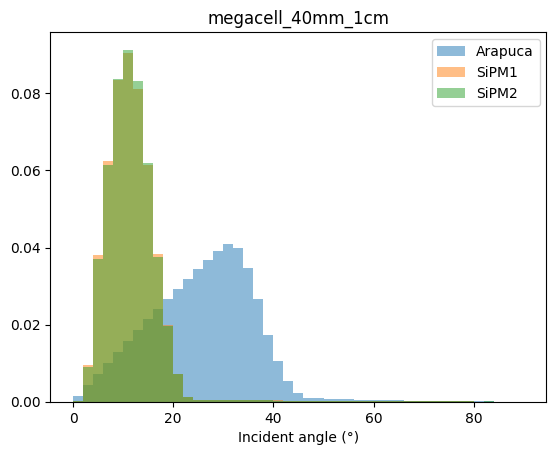

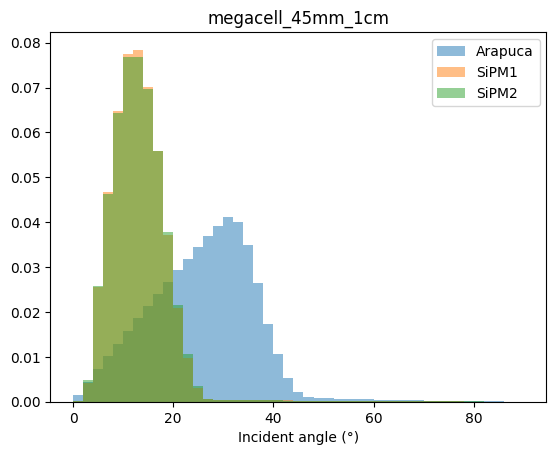

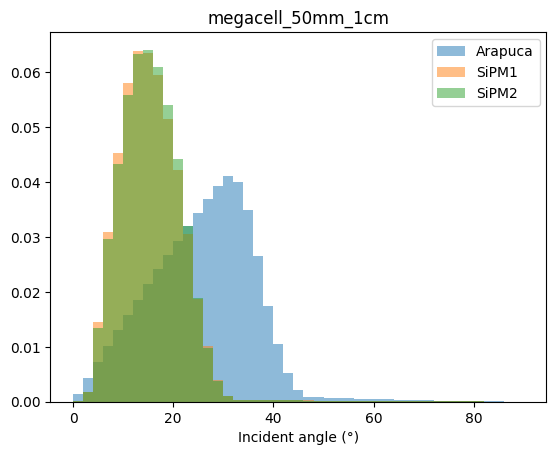

In [6]:
for d,my_data in enumerate(all_data): fig_ang = plot_angular_distributions(my_data,dpi=100)

<Figure size 320x240 with 0 Axes>

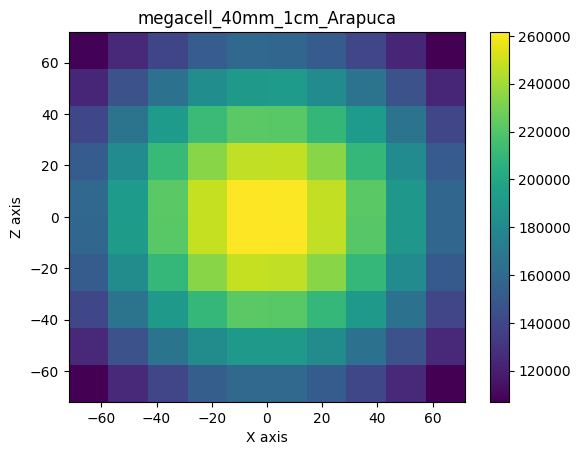

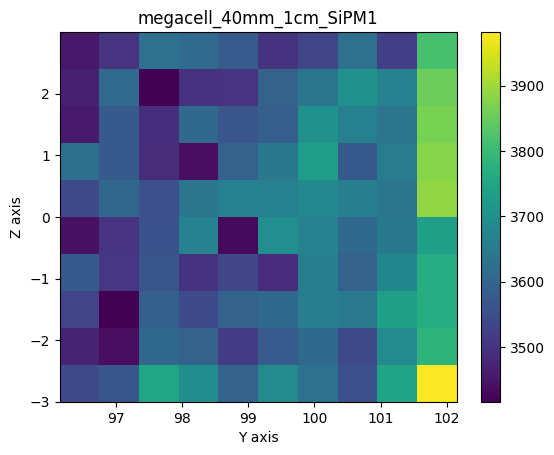

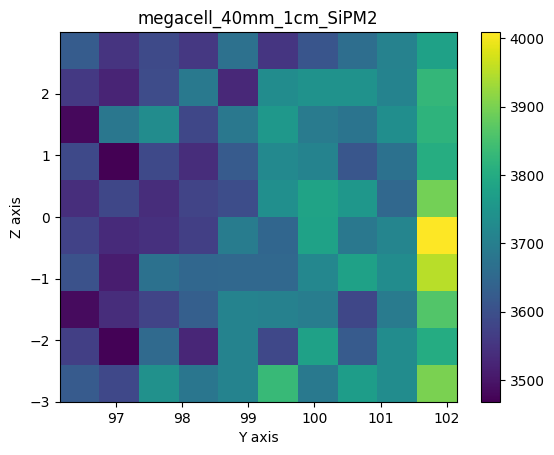

<Figure size 320x240 with 0 Axes>

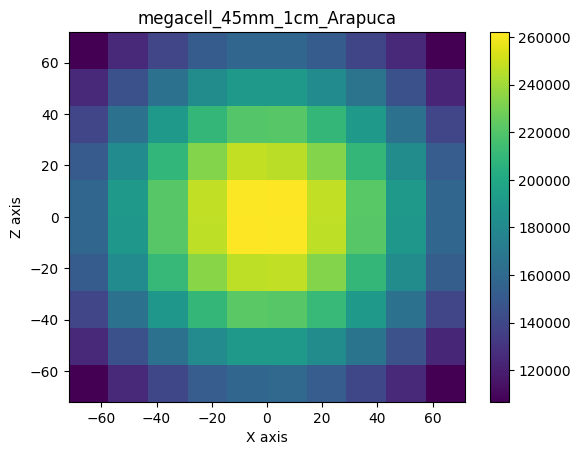

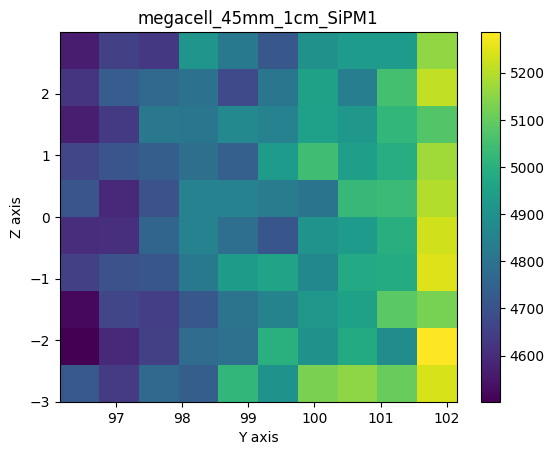

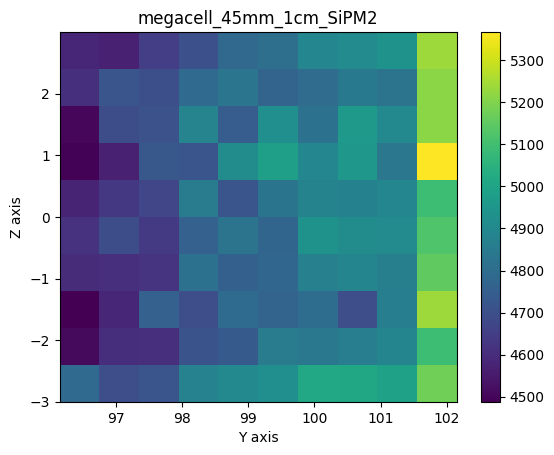

<Figure size 320x240 with 0 Axes>

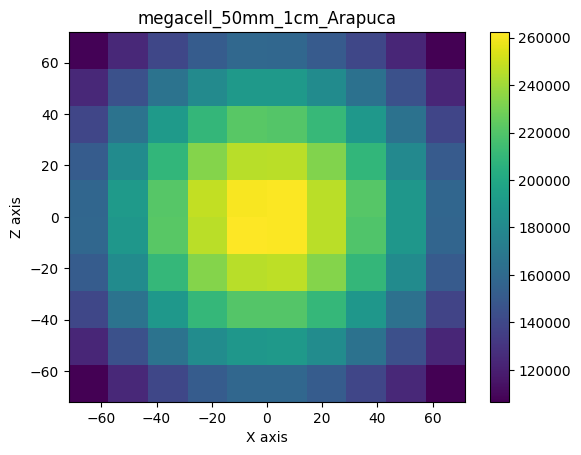

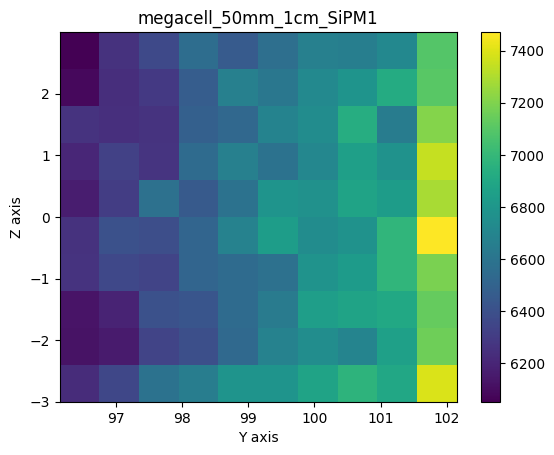

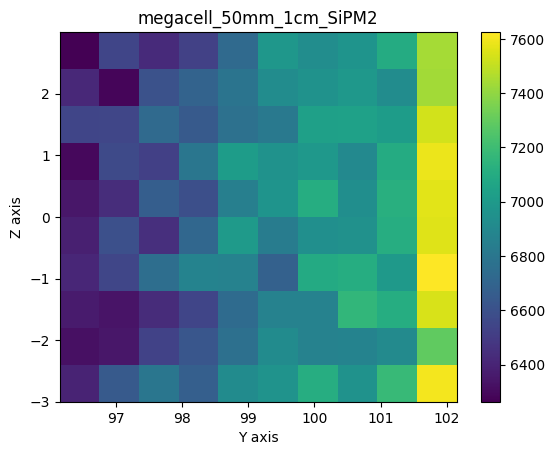

In [7]:
for d,my_data in enumerate(all_data): fig_ph = plot_photon_density(my_data,sensors_info,dpi=50)

In [9]:
all_data

[{'megacell_40mm_1cm.root': {'Arapuca': {'X': array([ -0.630517  , -12.73904273,  23.90795216, ...,  33.29720992,
            25.02882236,  66.04722448]),
    'Y': array([0.51, 0.51, 0.51, ..., 0.51, 0.51, 0.51]),
    'Z': array([ -6.2532766 ,   6.6837655 ,  34.10263362, ..., -58.55164587,
            -2.59644595,  30.77937198]),
    'Phi': array([-1.49849939, -1.61528917, -1.27072151, ..., -1.27146627,
           -1.56218097, -1.01226507]),
    'Theta': array([1.65578234, 1.53132302, 1.28784975, ..., 2.08691783, 0.85889099,
           1.34656145]),
    'Sensor': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 

In [122]:
def plot_acumhits(my_data,dpi=50,bins=[100,35,35],semilogy=False):
    for my_file in my_data:
        means = [];sensors = []
        for s,sensor in enumerate(my_data[my_file]): mean = np.mean(my_data[my_file][sensor]["AccumHits"]); means.append(mean); sensors.append(sensor)
        
        if np.any(np.array(means/means[0]) < 0.1) or np.any(np.array(means/means[0]) > 10): 
            fig, axs = plt.subplots(1,2,sharey=True,dpi=dpi); 
            axs[1].hist(my_data[my_file][sensors[0]]["AccumHits"], bins[0], alpha=0.5, histtype="step", color="C"+str(0),label=sensors[0]+" (Mean %0.2f)"%means[0])
            axs[1].set_xlim(means[0]-means[0]*0.8,means[0]+means[0]*1.1)
            if semilogy: axs[1].semilogy()
            for diff in list(np.where(np.array(means/means[0]) < 0.1)[0]) + list(np.where(np.array(means/means[0]) > 10)[0]):
                axs[0].hist(my_data[my_file][sensors[diff]]["AccumHits"], bins[diff], alpha=0.5, histtype="step", color="C"+str(diff),label=sensors[diff]+" (Mean %0.2f)"%means[diff])
                axs[0].set_xlim(means[diff]-means[diff]*0.8,means[diff]+means[diff]*1.6)
                if semilogy: axs[0].semilogy()
        else: 
            fig, axs = plt.subplots(1,1,sharey=True,dpi=dpi)
            for s,sensor in enumerate(my_data[my_file]):
                axs.hist(my_data[my_file][sensor]["AccumHits"], bins[s], alpha=0.5, histtype="step", color="C"+str(s),label=sensor+" (Mean %0.2f)"%means[s])
        
        fig.suptitle(my_file.replace(".root",""))
        fig.legend()
        fig.show()

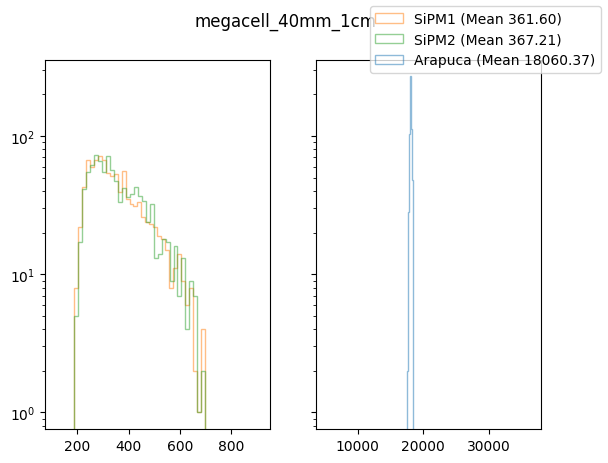

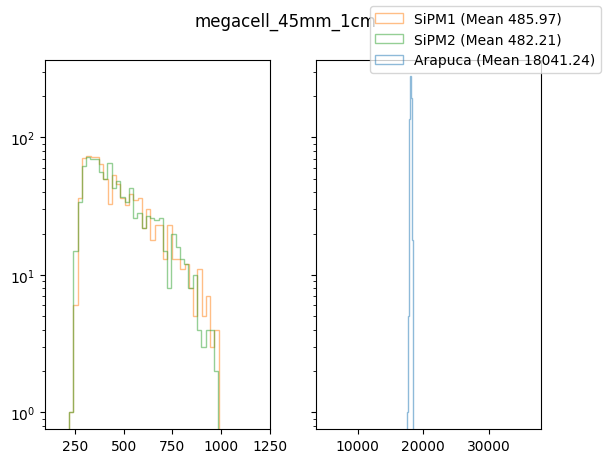

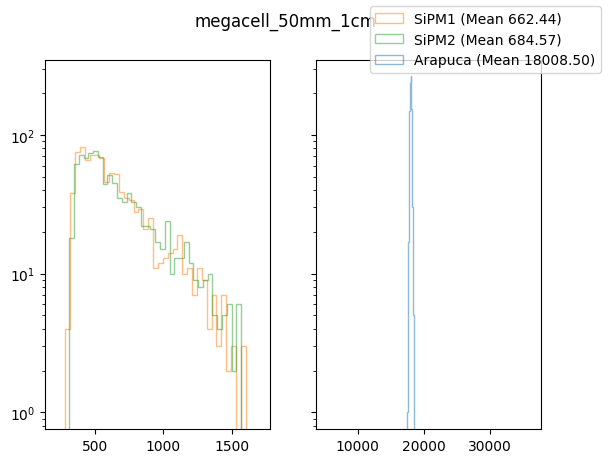

In [123]:
for d,my_data in enumerate(all_data): fig_acum = plot_acumhits(my_data,dpi=100,semilogy=True,bins=[200,45,45])